
# Flower Classification with TPU #

In this notebook, we use Convolutional Neural Network to classify flowers into different classes. For more information on the data-set, see TensorFlow flowers [data set](https://www.tensorflow.org/datasets/catalog/tf_flowers). 
In order to speed up classificaiton, we make use of Tensor Processing Units (TPU), which are available from [Kaggle](https://www.kaggle.com/docs/tpu). 

We consider different augmentations to the data-set, and different regularisation and learning rates for the pre-trained models.

This code, particularly the creating the flower data-sets is adapted from the the Ryan Holbrook's notebook [available here](https://www.kaggle.com/ryanholbrook/create-your-first-submission) 

In [28]:
# Imports
import math, re, os
import numpy as np
import tensorflow as tf
import pandas as pd
import random
from matplotlib import pyplot as plt
import h5py 
from sklearn.metrics import f1_score

# Dataset
from kaggle_datasets import KaggleDatasets

## Defining the Distribution Strategy

TPUs have advantages with processing large matrix mutliplacations. For more information, see this TF [tutorial](https://codelabs.developers.google.com/codelabs/keras-flowers-tpu/index.html?index=..%2F..index#2). 
Below, we define the *distribution strategy*, which allows us to run out models on TPU. 

In [3]:
try: # See if TPU available
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else: # Otherwise use default strategy CPU / GPU
    strategy = tf.distribute.get_strategy() 

print("Number of accelerators: ", strategy.num_replicas_in_sync) #expect 8 if TPU

2022-10-25 11:40:28.050389: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-10-25 11:40:28.053809: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-10-25 11:40:28.053845: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-25 11:40:28.053872: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ffd7032ec5b4): /proc/driver/nvidia/version does not exist
2022-10-25 11:40:28.056671: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

Number of accelerators:  8


## Loading the Competition Data 

In order to use TPUs, datasets need to be stored in a [Google Cloud Storage bucket](https://cloud.google.com/storage/). Fortunately, Kaggle has made this competition dataset available in a Google Coud Storage bucket. We also need to process the files in from [TFRecords](https://www.kaggle.com/ryanholbrook/tfrecords-basics) into pairs of images and labels. 

The dataset already has folders for training (12753), validation (3712) and test (7382) data. However, the test dataset is not labelled - it is what is used to benchmark model performance on the leaderboard. So that we can have a labelled test dataset, we are going to divide the data in the validation folder into validation and test data-sets.

Thus we having the following datasets:

- Test dataset : 12753
- Validation dataset : 1856
- Test dataset : 1856
- Prediction dataset : 7382

Ignoring the prediction dataset (the unlabelled test dataset), this corresponds to roughly 80:10:10 split.

For tips on further optimising the data reading in process, see [here](https://www.tensorflow.org/guide/data_performance)

In [4]:
# illustration for how lambda functions work, and how to pass functions as arguments into others
def f(x, c):
    return x*c

def apply_func(f, x):
    print(f(x))
    
    
f_3 = lambda x: f(x, 3)

apply_func(f_3, 2)

6


## Run Me: Image Processing Functions defined below

In [5]:
# Image processing files
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) tuples

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of (image, id) tuples 

def load_dataset(filenames, labeled=True, ordered=False):
    """
    Returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    """
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    return dataset

def data_augment(image, label, flip=False, rotate=False, saturate=False, hue=False):
    """
    Applies random augmentations to the data:
    - flip: randomly flip along vertical axis
    - rotate: rotate by k*90 where k is chosen uniformly from {0,1,2,3}
    - saturate: randomly adjusts the "colourfullness" of the image https://en.wikipedia.org/wiki/Colorfulness
    - hue: radnomly adjusts the hue of the image https://en.wikipedia.org/wiki/Hue 
    """
    if flip: image = tf.image.random_flip_left_right(image)              # flip along vertical axis
    if rotate: image = tf.image.rot90(image, k=random.choice([0,1,2,3])) # rotates image by k*90 degress  
    if saturate: image = tf.image.random_saturation(image, 0, 2)         # adjust saturation of images
    if hue: image = tf.image.random_hue(image, 0.1)                      # adds random hue changes to image
    return image, label   


def prepare_dataset(file_name, labeled=True, ordered=False, training=False, augment=None):
    """
    Prepares a train, validation or test either with or without labels (as in the case of the predict set)
    Args:
        file_name: str, list of filenames of TFRecords
        labeled: bool, whether the TFRecords are image, label or image, id pairs
        ordered: bool, whether to fetch the file names in order 
        training: bool, if true, dataset is repeated and shuffled
        augment: function(image, label) -> (image, label) returns an augmented image
    """
    
    dataset = load_dataset(file_name, labeled=labeled, ordered = ordered)
    
    if augment:
        dataset = dataset.map(augment, num_parallel_calls=AUTO) # augments data with supplied function
    
    if training:
        dataset = dataset.repeat()      # the training dataset must repeat for several epochs
        dataset = dataset.shuffle(2048) # 2048 is the buffersize 
    
    return dataset

def configure_for_performance(dataset):
    """
    Batches and prefetches data. See cache, interleave also in https://www.tensorflow.org/guide/data_performance
    """
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)    # prefetch next batch while training (autotune prefetch buffer size)
    return dataset
    
def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec
    # files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [6]:
CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                  

GCS_DS_PATH = KaggleDatasets().get_gcs_path('tpu-getting-started') #define path to google cloud storage bucket

# we use the 512x512x3 data 
IMAGE_SIZE = [512, 512]
GCS_PATH = GCS_DS_PATH + f'/tfrecords-jpeg-{IMAGE_SIZE[0]}x{IMAGE_SIZE[1]}'
AUTO = tf.data.experimental.AUTOTUNE

# note we are going to split up the validation folder into validation and test data
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VAL_TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
PRED_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') 

print("Number of observations in each file:")
NUM_TRAIN = count_data_items(TRAINING_FILENAMES)
NUM_VAL_TEST = count_data_items(VAL_TEST_FILENAMES)
NUM_VAL = NUM_VAL_TEST//2
NUM_TEST = NUM_VAL_TEST - NUM_VAL
NUM_PRED = count_data_items(PRED_FILENAMES)
print(f"Train: {NUM_TRAIN}\nValidation: {NUM_VAL}\nTest: {NUM_TEST}\nUnlabelled Test: {NUM_PRED}")

2022-10-25 11:40:34.615524: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-10-25 11:40:34.702418: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-10-25 11:40:34.772451: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


Number of observations in each file:
Train: 12753
Validation: 1856
Test: 1856
Unlabelled Test: 7382


In [7]:
# Define the batch size. This will be 16 with TPU off and 128 (=16*8) with TPU on
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

# Define the unaugmented (default) datasets
train_ds = configure_for_performance(prepare_dataset(TRAINING_FILENAMES, labeled=True, training=True))
val_test_ds = prepare_dataset(VAL_TEST_FILENAMES, labeled=True)
val_ds = configure_for_performance(val_test_ds.take(NUM_VAL))
test_ds = configure_for_performance(val_test_ds.skip(NUM_VAL).take(NUM_TEST))
pred_ds = configure_for_performance(prepare_dataset(PRED_FILENAMES, labeled=False, ordered=True))

print("Training:", train_ds)
print ("Validation:", val_ds)
print("Test:", test_ds)
print("Predict:", pred_ds)

Training: <PrefetchDataset shapes: ((None, 512, 512, 3), (None,)), types: (tf.float32, tf.int32)>
Validation: <PrefetchDataset shapes: ((None, 512, 512, 3), (None,)), types: (tf.float32, tf.int32)>
Test: <PrefetchDataset shapes: ((None, 512, 512, 3), (None,)), types: (tf.float32, tf.int32)>
Predict: <PrefetchDataset shapes: ((None, 512, 512, 3), (None,)), types: (tf.float32, tf.string)>


2022-10-25 11:40:39.245614: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 86, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1666698039.242304727","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 86, Output num: 0","grpc_status":3}


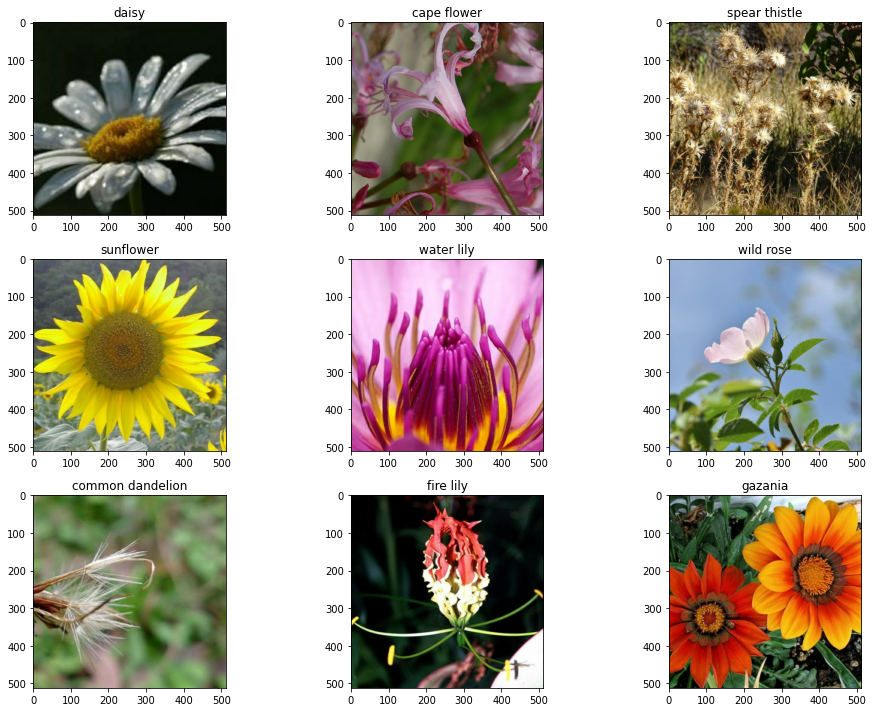

In [9]:
fig, axs = plt.subplots(3, 3, figsize=(14,10))
axs = axs.flatten()
#Plot an example from the training data-set
for (img, class_ind), ax in zip(test_ds.unbatch().take(9),  axs):
    ax.imshow(img)
    ax.set_title(CLASSES[class_ind])

plt.tight_layout()
plt.show()

## Plot Distributions of Classes in Train, Test, Validation sets

We want to see how many flowers there are in each class. This will give us a sense of how well a most frequent label classifier would do. 

In [10]:
#This takes a little while
prepare_deterministic = lambda file_name: prepare_dataset(file_name, labeled=True, ordered=True)
train = prepare_deterministic(TRAINING_FILENAMES)
val_test = prepare_deterministic(VAL_TEST_FILENAMES)
val = val_test.take(NUM_VAL)
test = val_test.skip(NUM_VAL).take(NUM_TEST)

#see if there is a more effecient ways of extracting the labels/class indices from each dataset
get_indices = lambda ds: np.array(list(ds.map(lambda image, index: index).as_numpy_iterator()))
y_train = get_indices(train)
y_val = get_indices(val)
y_test = get_indices(test)
print("Done complicated label extraction")

#get label counts - figure out how to make np array mixed type - it currently converts the counts to strings
count_labels = lambda indices: np.asarray([[label, (indices == index).sum()] for index, label in enumerate(CLASSES)])
train_counts = count_labels(y_train)
val_counts = count_labels(y_val)
test_counts = count_labels(y_test)

Done complicated label extraction


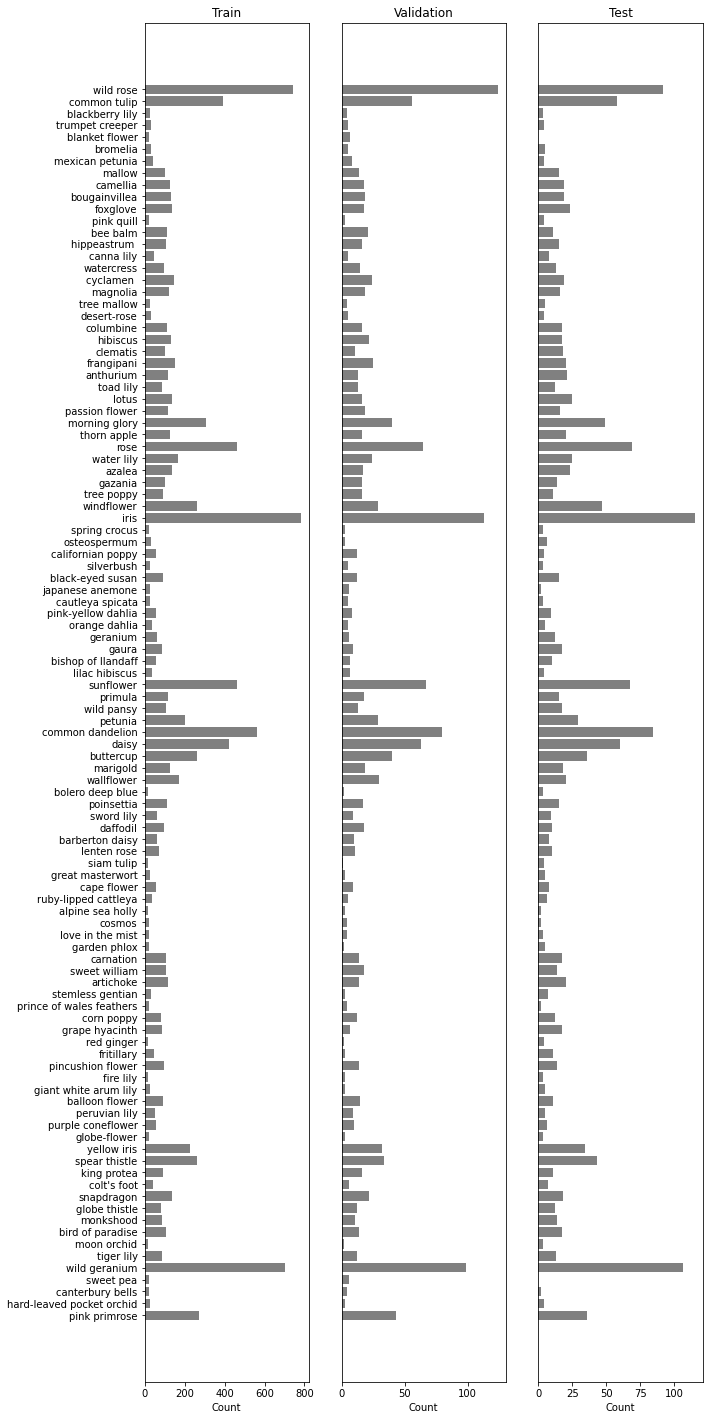

In [11]:
def plot_label_dist(label_counts, name = "", y_blank=False):
    plt.barh(label_counts[:,0], label_counts[:,1].astype(int), color="grey")
    plt.xlabel("Count")
    plt.title(name)
    if y_blank: plt.yticks([])

plt.figure(figsize=(10,25))
plt.subplot(1,3,1)
plot_label_dist(train_counts, "Train")
plt.subplot(1,3,2)
plot_label_dist(val_counts, "Validation", True)
plt.subplot(1,3,3)
plot_label_dist(test_counts, "Test", True)

## Weak Baseline

If we classified every observation in the test data-set with the most frequent label in the training dataset, *iris*, we would achieve an accuracy of 5.71%.

In [12]:
ind = np.argmax(train_counts[:,1].astype(int)) # index of most frequent label
m_f_l = train_counts[ind,0]                    # most frequent label - iris
tc = float(test_counts[ind,1])                 # number of occurences of iris in test set
print(f"Most frequent label classifier accuracy: {round(tc/NUM_TEST,4)}")

Most frequent label classifier accuracy: 0.062


# Model Design 

We make use of *transfer learning*, where we use a pretrained model and append additional fully connected layers on the end so we can exploit the pretrained "learnt" representations, and then just have to learn how to map these learnt representations to classifications. We may consider more models, but at this stage, we consider:

- VGGNet [(Simonyan and Zisserman, 2014)](https://arxiv.org/abs/1409.1556)
- ResNet [(He et al, 2016)](https://openaccess.thecvf.com/content_cvpr_2016/html/He_Deep_Residual_Learning_CVPR_2016_paper.html)


These models were pretrained on the [ImageNet](http://image-net.org/) dataset. At a later stage, we can also start fine tuning these models: see [here](https://keras.io/guides/transfer_learning/) 

### Metrics and Loss

We use cross-entropy as the loss function. The reason we use `sparse_categorical_crossentropy` as opposed to `categorical_crossentropy` is since the responses that are not hot-one encodings, e.g. [0,0,1], but rather as numbers, e.g. [3]. 

What are precision and recall in this context?

### TPU

For training these models with TPU, as Ryan Holbrook said, *"The distribution strategy we created earlier contains a [context manager](https://docs.python.org/3/reference/compound_stmts.html#with), `strategy.scope`. This context manager tells TensorFlow how to divide the work of training among the eight TPU cores. When using TensorFlow with a TPU, it's important to define your model in a `strategy.scope()` context."*

In [13]:
def build_model(pretrained_model, dropout=None, f_c_units=[]):
    """
    Defines a CNN with:
        - a pretrained_model followed by
        - a global average pooling layer
        - optional dropout, dropout defines the probability of dropping a neuron
        - a number of fully connected layers, the last of which has 104 outputs
    """

    with strategy.scope():
        feature_model = pretrained_model(
            weights ='imagenet',
            include_top = False ,
            input_shape=[*IMAGE_SIZE, 3]
        )
        feature_model.trainable = False # Freezes all the pretrained models weights

        model = tf.keras.Sequential(name=f"{feature_model.name}_drop{dropout}_units{'_'.join(map(str, f_c_units))}")
        model.add(feature_model)
        model.add(tf.keras.layers.GlobalAveragePooling2D()) # add global average pooling
        
        if dropout: 
            model.add(tf.keras.layers.Dropout(dropout)) # optionally add dropout
        
        for units in f_c_units: #add number of fully connected layers to model
            model.add(tf.keras.layers.Dense(units, activation='relu'))
            if dropout:
                model.add(tf.keras.layers.Dropout(dropout)) # optionally add dropout
        
        model.add(tf.keras.layers.Dense(len(CLASSES), activation='softmax')) # final fully connected layer
        

    model.compile(
        optimizer='adam',
        loss = 'sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'],
    )

    return model
    

### Callbacks

We make use of early stopping and a learning rate scheduler. For early stopping, we monitor the validation loss and terminate training if it stops decreasing for 3 epochs (`patience=3`). The scheduler caues the learning rate to ramp up for a number of epochs, sustain for a number of epochs and then decay. 

Why the ramp up: [Someone's StackOverflow opinion](https://stackoverflow.com/questions/55933867/what-does-learning-rate-warm-up-mean)

In [14]:
def get_callbacks():
    #early stopping
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)
    
    #learning rate scheduler
    lr_callback = tf.keras.callbacks.LearningRateScheduler(exponential_lr, verbose=True)
    
    return [es_callback, lr_callback]

def exponential_lr(epoch, 
                   start_lr = 0.00001, min_lr = 0.00001, max_lr = 0.00005,
                   rampup_epochs = 5, sustain_epochs = 0, exp_decay = 0.8):
    # linear increase from start to rampup_epochs
    if epoch < rampup_epochs:
        lr = ((max_lr - start_lr) / rampup_epochs * epoch + start_lr)
    # constant max_lr during sustain_epochs
    elif epoch < rampup_epochs + sustain_epochs:
        lr = max_lr
    # exponential decay towards min_lr
    else:
        lr = ((max_lr - min_lr) *
              exp_decay**(epoch - rampup_epochs - sustain_epochs) +
              min_lr)
    return lr

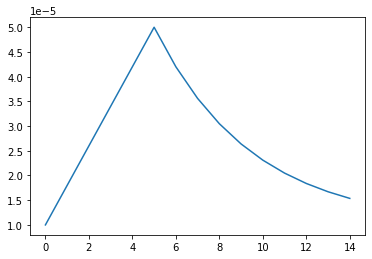

In [29]:
#illsutration of learning rate
rng = [i for i in range(15)]
y = [exponential_lr(x) for x in rng]
plt.plot(rng, y)
plt.show()

## Strong Baselines: Evaluating architectures without any regularisation except early stopping

In [16]:
base_models = [
    tf.keras.applications.ResNet50V2,
    tf.keras.applications.densenet.DenseNet201,
    tf.keras.applications.Xception,
]

baselines = []
for base in base_models:
    built_model = build_model(base)
    print(built_model.summary)
    baselines.append(built_model)


94674944/94668760 [==============================] - 0s 0us/step
<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fb40cdd5c90>>
74842112/74836368 [==============================] - 0s 0us/step
<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fb3f04e8310>>
83689472/83683744 [==============================] - 1s 0us/step
<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fb3f0274b10>>


In [17]:
EPOCHS = 15
STEPS_PER_EPOCH = NUM_TRAIN // BATCH_SIZE # Total number of steps (batches of samples) per epoch 

histories = {} #collect the train and val trajectories for each model

In [18]:
#let training begin
for model in baselines:
    histories[model.name] = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks=get_callbacks())

Epoch 1/15

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
99/99 [==============================] - 43s 290ms/step - loss: 3.3605 - sparse_categorical_accuracy: 0.2756 - val_loss: 1.6084 - val_sparse_categorical_accuracy: 0.6670
Epoch 2/15

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0008100000379979611.
 1/99 [..............................] - ETA: 14s - loss: 1.4862 - sparse_categorical_accuracy: 0.6562

2022-10-25 11:43:15.782502: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 124302, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1666698195.782406307","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 124302, Output num: 0","grpc_status":3}


99/99 [==============================] - 18s 185ms/step - loss: 1.3718 - sparse_categorical_accuracy: 0.7236 - val_loss: 1.1529 - val_sparse_categorical_accuracy: 0.7586
Epoch 3/15

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0005060000335611404.
99/99 [==============================] - 18s 184ms/step - loss: 0.9714 - sparse_categorical_accuracy: 0.8087 - val_loss: 1.0016 - val_sparse_categorical_accuracy: 0.7909
Epoch 4/15

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00023240000449121004.
99/99 [==============================] - 19s 197ms/step - loss: 0.8245 - sparse_categorical_accuracy: 0.8432 - val_loss: 0.9409 - val_sparse_categorical_accuracy: 0.8028
Epoch 5/15

Epoch 00005: LearningRateScheduler reducing learning rate to 8.648000176530332e-05.
99/99 [==============================] - 19s 195ms/step - loss: 0.7624 - sparse_categorical_accuracy: 0.8576 - val_loss: 0.9231 - val_sparse_categorical_accuracy: 0.8055
Epoch 6/15

Epoch 00006: Learni

2022-10-25 11:48:55.384945: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 142231, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1666698535.384727634","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 142231, Output num: 1","grpc_status":3}


Epoch 2/15

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0008100000379979611.
99/99 [==============================] - 26s 268ms/step - loss: 2.1273 - sparse_categorical_accuracy: 0.5699 - val_loss: 1.7620 - val_sparse_categorical_accuracy: 0.6379
Epoch 3/15

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0005060000335611404.
99/99 [==============================] - 26s 266ms/step - loss: 1.5946 - sparse_categorical_accuracy: 0.6915 - val_loss: 1.5242 - val_sparse_categorical_accuracy: 0.7058
Epoch 4/15

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00023240000449121004.
99/99 [==============================] - 26s 267ms/step - loss: 1.3756 - sparse_categorical_accuracy: 0.7440 - val_loss: 1.4325 - val_sparse_categorical_accuracy: 0.7214
Epoch 5/15

Epoch 00005: LearningRateScheduler reducing learning rate to 8.648000176530332e-05.
99/99 [==============================] - 26s 266ms/step - loss: 1.3014 - sparse_categorical_accuracy: 0.7

2022-10-25 11:55:45.339629: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 159390, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1666698945.339549700","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 159390, Output num: 1","grpc_status":3}


Epoch 2/15

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0008100000379979611.
99/99 [==============================] - 20s 204ms/step - loss: 2.1900 - sparse_categorical_accuracy: 0.5421 - val_loss: 1.8525 - val_sparse_categorical_accuracy: 0.6277
Epoch 3/15

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0005060000335611404.
99/99 [==============================] - 19s 196ms/step - loss: 1.7231 - sparse_categorical_accuracy: 0.6554 - val_loss: 1.6348 - val_sparse_categorical_accuracy: 0.6708
Epoch 4/15

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00023240000449121004.
99/99 [==============================] - 19s 196ms/step - loss: 1.5123 - sparse_categorical_accuracy: 0.7009 - val_loss: 1.5488 - val_sparse_categorical_accuracy: 0.6886
Epoch 5/15

Epoch 00005: LearningRateScheduler reducing learning rate to 8.648000176530332e-05.
99/99 [==============================] - 20s 205ms/step - loss: 1.4399 - sparse_categorical_accuracy: 0.7

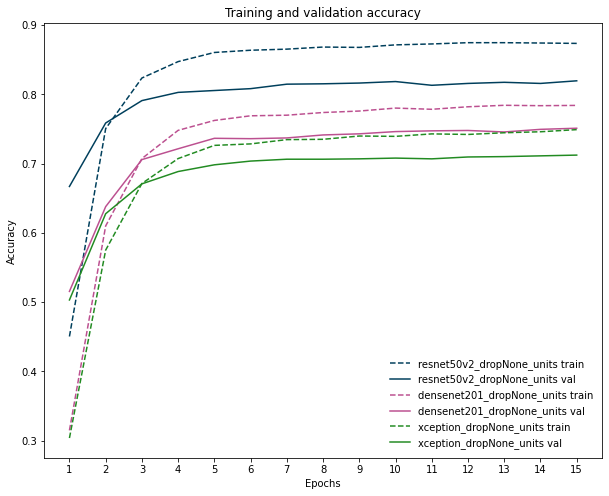

In [19]:
# Plot Train and Validation accuracy
plt.figure(figsize=(10,8))               #set size of graph
mn = [model.name for model in baselines] #collect model names 
colours = ["#003f5c","#bc5090", "#228b22"]          #define colours (add more colours if more models considered)

for i in range(len(mn)):
    history_dict = histories[mn[i]].history
    loss = history_dict['sparse_categorical_accuracy']
    val_loss = history_dict['val_sparse_categorical_accuracy']

    epochs = range(1, len(loss) + 1)
    plt.xticks(np.arange(1,21, 1))
    plt.plot(epochs, loss, label=mn[i]+" train", linestyle="--", color=colours[i])
    plt.plot(epochs, val_loss, label=mn[i]+" val", color=colours[i])
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

plt.legend(frameon=False)
plt.show()

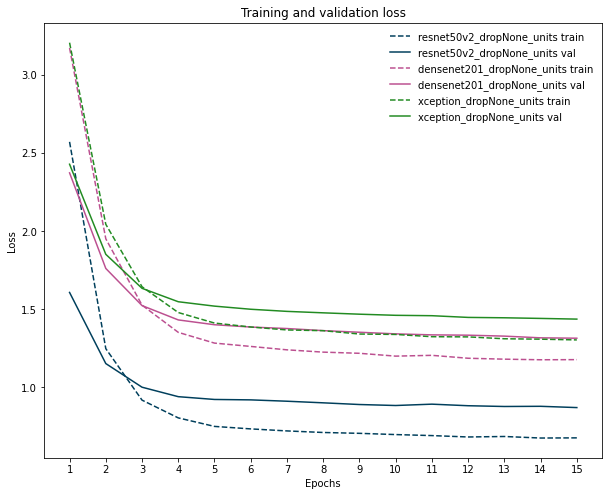

In [20]:
# Plot Train and Validation loss
plt.figure(figsize=(10,8))                #set size of graph

for i in range(len(mn)):
    history_dict = histories[mn[i]].history
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(loss) + 1)
    plt.xticks(np.arange(1,21, 1))
    plt.plot(epochs, loss, label=mn[i]+" train", linestyle="--", color=colours[i])
    plt.plot(epochs, val_loss, label=mn[i]+" val", color=colours[i])
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

plt.legend(frameon=False)
plt.show()

In [31]:
# Save histories

# Make directory for histories
history_dir = "./model_history"
os.makedirs(history_dir, exist_ok=True)

for model in baselines:
    model_name = model.name
    model_train_history = histories[model_name].history
    
    hist_file_name = model_name + "_training_history.csv"
    csv_path = os.path.join(history_dir, hist_file_name)
    
    # Save to csv file
    df = pd.DataFrame(model_train_history)
    df.to_csv(csv_path)
    print(f"Saved history to {csv_path}")
    

Saved history to resnet50v2_dropNone_units_training_history.csv
Saved history to densenet201_dropNone_units_training_history.csv
Saved history to xception_dropNone_units_training_history.csv


In [32]:
# Save Weights

# Make directory for model weights
weights_dir = "./model_weights"
os.makedirs(weights_dir, exist_ok=True)


for model in baselines:
    model_name = model.name
    weights_file_name = model_name + "_trained_weights.h5"
    h5_path = os.path.join(weights_dir, weights_file_name)

    #save model weights
    model.save_weights(h5_path) 
    print(f"Saved weights to {h5_path}")

Saved weights to resnet50v2_dropNone_units_trained_weights.h5
Saved weights to densenet201_dropNone_units_trained_weights.h5
Saved weights to xception_dropNone_units_trained_weights.h5


In [35]:
for model in baselines:
    print(f"Model: {model.name}")
    model.evaluate(test_ds)

Model: resnet50v2_dropNone_units
15/15 [==============================] - 5s 151ms/step - loss: 0.8765 - sparse_categorical_accuracy: 0.81570.8765 - sparse_categorical_accuracy: 0.81
Model: densenet201_dropNone_units


2022-10-25 12:05:12.298788: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 187641, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1666699512.298728961","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 187641, Output num: 0","grpc_status":3}


15/15 [==============================] - 4s 184ms/step - loss: 1.2800 - sparse_categorical_accuracy: 0.7452
Model: xception_dropNone_units
15/15 [==============================] - 3s 132ms/step - loss: 1.3948 - sparse_categorical_accuracy: 0.7220


Based on these initial results, we can see that big difference between the performance of the ResNet50 when compared to the DenseNet and Xception.

We will create an ensemble prediction using combinations of these 3 models.

## Hyper-parameter optimisation

1. Different amounts of dropout - lienar search on best model
2. Different types of image augmentation 

more (time permitting):

    Number of fully connected layers appended to model

We start by doing a random search through the 32 different combinations of data augmentation we can apply:

All 25 subsets of {flip, rotate, contrast shift, hue shift, saturation shift}

We prepare different augmentations of training datasets using the function:

data_augment(image, label, flip, rotate, contrast, saturate, hue)

See this tutorial for how you might be able to distribute the hyper-parameter search more efficiently: https://www.tensorflow.org/guide/tpu#train_a_model_using_keras_high_level_apis

In [ ]:
# Searching for best drop out

# models_ResNet = efn.EfficientNetB7
# dropout_params = np.round(np.linspace(0.4, 0.005, 5), 6)

# drop_out_models = [build_model(models_ResNet, name = str(np.round(param, 4)), dropout = float(str(np.round(param, 4))) ) for param in dropout_params]


# for m in models:
#     m.summary()

In [ ]:
def get_labels_from_tfdataset(tfdataset, batched=False):
    labels = list(map(lambda x: x[1], tfdataset)) # Get labels 
    
    if not batched:
        return tf.concat(labels, axis=0) # concat the list of batched labels
    
    return labels

In [50]:
# Find Best Alpha with Validation sets

# f1_with average='marco' means: Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.


images_ds = val_ds.map(lambda image, label: image)
val_true_labels = get_labels_from_tfdataset(val_ds)

m1 = baselines[2].predict(images_ds)
m2 = baselines[1].predict(images_ds)

scores = []
for alpha in np.linspace(0,1,100):
    val_probabilities = alpha * m1 + (1-alpha) * m2
    val_predictions = np.argmax(val_probabilities, axis=-1)
    scores.append(f1_score(val_true_labels, val_predictions, labels=range(104), average='macro'))

best_alpha = np.argmax(scores)/100
print('Best alpha: ' + str(best_alpha))


Best alpha: 0.43


In [58]:
# Find Best Alpha with Validation sets

# f1_with average='marco' means: Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.


images_ds = val_ds.map(lambda image, label: image)
val_true_labels = get_labels_from_tfdataset(val_ds)

m1 = baselines[0].predict(images_ds)
m2 = baselines[1].predict(images_ds)

scores = []
for alpha in np.linspace(0,1,100):
    val_probabilities = alpha * m1 + (1-alpha) * m2
    val_predictions = np.argmax(val_probabilities, axis=-1)
    scores.append(f1_score(val_true_labels, val_predictions, labels=range(104), average='macro'))

best_alpha = np.argmax(scores)/100
print(f"Best alpha: {str(best_alpha)} with score of  {np.max(scores)}")


Best alpha: 0.13 with score of  0.016034694431615665


## Best Alphas

ResNet and DenseNet: 0.27 with F1_score=0.017 (OR 0.13 with F1_score=0.0160)

Xception and DenseNet: 0.2 with F1_score=0.016

ResNet and Xception: 0.21 with F1_score=0.011

In [60]:
model1 = baselines[0]
model2 = baselines[1]
best_alpha = 0.27

## Make Predictions

We will use an ensemble of two models to make predictions

In [62]:
pred_images_ds = pred_ds.map(lambda image, idnum: image) #extract images from pred_ds
probabilities_1 = model1.predict(pred_images_ds) #use the ResNet baseline at this stage
probabilities_2 = model2.predict(pred_images_ds)

probabilities = best_alpha * probabilities_1 + (1 - best_alpha) * probabilities_2

predictions = np.argmax(probabilities, axis=-1)
print(predictions)

2022-10-25 12:24:40.855296: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 200481, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1666700680.854908485","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 200481, Output num: 0","grpc_status":3}


[ 67  28  77 ... 103 102  62]


In [63]:
# Get image ids from test set and convert to unicode
pred_ids_ds = pred_ds.map(lambda image, idnum: idnum).unbatch()
pred_ids = next(iter(pred_ids_ds.batch(NUM_PRED))).numpy().astype('U')

# Write the submission file
np.savetxt(
    'submission.csv',
    np.rec.fromarrays([pred_ids, predictions]),
    fmt=['%s', '%d'],
    delimiter=',',
    header='id,label',
    comments='',
)

# Look at the first few predictions
!head submission.csv

id,label
252d840db,67
1c4736dea,28
c37a6f3e9,77
00e4f514e,103
59d1b6146,70
8d808a07b,53
aeb67eefb,103
53cfc6586,48
aaa580243,82
